# Prediction of Remaining Useful Lifetime (RUL) of turbofan engine using Random Forests

# Dataset

**Experimental Scenario**

Data sets consists of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine ñ i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.

The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective of the competition is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. Also provided a vector of true Remaining Useful Life (RUL) values for the test data.
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1. unit number
2. time, in cycles
3. operational setting 1
4. operational setting 2
5. operational setting 3
6. sensor measurement  1
7. sensor measurement  2
* ...
26. sensor measurement  26


**Reference:**  A. Saxena, K. Goebel, D. Simon, and N. Eklund, ìDamage Propagation Modeling for Aircraft Engine Run-to-Failure Simulationî, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

# Import required libraries

In [2]:
import fastai
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import random
from fastai.imports import *
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics
from structured import * 

# Useful Functions

In [3]:
# Explore dataframe
def exploreData (data):
    
    print("Data Set Dimensions : {}".format(data.shape))
    
    #print ("\n")
    
    #print ("Data Sample (First 2 rows) : ")
    #print (data.head(2).T)
    
    print ("\n")
    print ("Data Set Type :")
    print("{}".format(data.dtypes))
    
    print ("\n")
    print ("Null Data :")
    print (data.isnull().sum())
    print ("\n")
    print ("Missing Data :")
    print (data.isna().sum())

In [4]:
MAXLIFE = 120
SCALE = 1
RESCALE = 1
true_rul = []
test_engine_id = 0
training_engine_id = 0

def kink_RUL(cycle_list, max_cycle):
    
    knee_point = max_cycle - MAXLIFE
    kink_RUL = []
    stable_life = MAXLIFE
    for i in range(0, len(cycle_list)):
        if i < knee_point:
            kink_RUL.append(MAXLIFE)
        else:
            tmp = kink_RUL[i - 1] - (stable_life / (max_cycle - knee_point))
            kink_RUL.append(tmp)

    # Returns the RUL for all 100 engines (FD001)
    return kink_RUL

def compute_rul_of_one_file(FD00X, id='engine_id', RUL_FD00X=None):
    '''
    Input train_FD001, output a list
    '''
    rul = []
    
    # In the loop train, each id value of the 'engine_id' column
    if RUL_FD00X is None:
        
        
        for _id in set(FD00X[id]):
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id]))
            
        return rul
    else:
        rul = []
        
        for _id in set(FD00X[id]):
            #print("#### id ####", int(RUL_FD00X.iloc[_id - 1]))
            true_rul.append(int(RUL_FD00X.iloc[_id - 1]))
            rul.extend(compute_rul_of_one_id(FD00X[FD00X[id] == _id], int(RUL_FD00X.iloc[_id - 1])))
        return rul

def compute_rul_of_one_id(FD00X_of_one_id, max_cycle_rul=None):
    '''
    Enter the data of an engine_id of train_FD001 and output the corresponding RUL (remaining life) of these data.
    type is list
    '''

    cycle_list = FD00X_of_one_id['cycle'].tolist()
    if max_cycle_rul is None:
        max_cycle = max(cycle_list)  # Failure cycle
    else:
        max_cycle = max(cycle_list) + max_cycle_rul
        # print(max(cycle_list), max_cycle_rul)

    # return kink_RUL(cycle_list,max_cycle)
    return kink_RUL(cycle_list, max_cycle)



def get_CMAPSSData(min_max_norm=False):
    '''
    :param min_max_norm: switch to enable min-max normalization
    :return: function will save the preprocessed training and testing data. 
    '''

    column_name = ['engine_id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                   's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                   's15', 's16', 's17', 's18', 's19', 's20', 's21']

    files=[1, 2, 3, 4]
    PATH = "../../dataset/turbofan/CMAPSSData"
    train_FD001 = pd.read_table(f"{PATH}/train_FD001.txt", header=None, delim_whitespace=True)
    train_FD002 = pd.read_table(f"{PATH}/train_FD002.txt", header=None, delim_whitespace=True)
    train_FD003 = pd.read_table(f"{PATH}/train_FD003.txt", header=None, delim_whitespace=True)
    train_FD004 = pd.read_table(f"{PATH}/train_FD004.txt", header=None, delim_whitespace=True)
    train_FD001.columns = column_name
    train_FD002.columns = column_name
    train_FD003.columns = column_name
    train_FD004.columns = column_name

    previous_len = 0
    frames = []
    for data_file in ['train_FD00' + str(i) for i in files]:  # load subdataset by subdataset

        #### standard normalization ####
        mean = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].mean()
        std = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].std()
        std.replace(0, 1, inplace=True)
        # print("std", std)
        ################################

        if min_max_norm:
            scaler = MinMaxScaler()
            eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = scaler.fit_transform(
                eval(data_file).iloc[:, 2:len(list(eval(data_file)))])
        else:
            eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = (eval(data_file).iloc[:, 2:len(
                list(eval(data_file)))] - mean) / std

        eval(data_file)['RUL'] = compute_rul_of_one_file(eval(data_file))
        current_len = len(eval(data_file))
        print(eval(data_file).index)
        eval(data_file).index = range(previous_len, previous_len + current_len)
        previous_len = previous_len + current_len
        print(eval(data_file).index)
        frames.append(eval(data_file))
        print(data_file)

    train = pd.concat(frames)
    global training_engine_id
    training_engine_id = train['engine_id']
    train = train.drop('engine_id', 1)
    train = train.drop('cycle', 1)
      

    #train_values = train.values * SCALE
    
    #train_values = train.values * SCALE
    #np.save('normalized_train_data.npy', train_values)
    #train.to_csv('normalized_train_data.csv')
    ###########      

    test_FD001 = pd.read_table(f"{PATH}/test_FD001.txt", header=None, delim_whitespace=True)
    test_FD002 = pd.read_table(f"{PATH}/test_FD002.txt", header=None, delim_whitespace=True)
    test_FD003 = pd.read_table(f"{PATH}/test_FD003.txt", header=None, delim_whitespace=True)
    test_FD004 = pd.read_table(f"{PATH}/test_FD004.txt", header=None, delim_whitespace=True)
    test_FD001.columns = column_name
    test_FD002.columns = column_name
    test_FD003.columns = column_name
    test_FD004.columns = column_name

    # load RUL data
    RUL_FD001 = pd.read_table(f"{PATH}/RUL_FD001.txt", header=None, delim_whitespace=True)
    RUL_FD002 = pd.read_table(f"{PATH}/RUL_FD002.txt", header=None, delim_whitespace=True)
    RUL_FD003 = pd.read_table(f"{PATH}/RUL_FD003.txt", header=None, delim_whitespace=True)
    RUL_FD004 = pd.read_table(f"{PATH}/RUL_FD004.txt", header=None, delim_whitespace=True)
    RUL_FD001.columns = ['RUL']
    RUL_FD002.columns = ['RUL']
    RUL_FD003.columns = ['RUL']
    RUL_FD004.columns = ['RUL']

    previous_len = 0
    frames = []
    for (data_file, rul_file) in [('test_FD00' + str(i), 'RUL_FD00' + str(i)) for i in files]:
        mean = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].mean()
        std = eval(data_file).iloc[:, 2:len(list(eval(data_file)))].std()
        std.replace(0, 1, inplace=True)

        if min_max_norm:
            scaler = MinMaxScaler()
            eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = scaler.fit_transform(
                eval(data_file).iloc[:, 2:len(list(eval(data_file)))])
        else:
            eval(data_file).iloc[:, 2:len(list(eval(data_file)))] = (eval(data_file).iloc[:, 2:len(
                list(eval(data_file)))] - mean) / std

        eval(data_file)['RUL'] = compute_rul_of_one_file(eval(data_file), RUL_FD00X=eval(rul_file))
        current_len = len(eval(data_file))
        eval(data_file).index = range(previous_len, previous_len + current_len)
        previous_len = previous_len + current_len
        frames.append(eval(data_file))
        print(data_file)
        if len(files) == 1:
            global test_engine_id
            test_engine_id = eval(data_file)['engine_id']

    test = pd.concat(frames)
    test = test.drop('engine_id', 1)
    test = test.drop('cycle', 1)
        

    
    #test_values = test.values * SCALE
    #np.save('normalized_test_data.npy', test_values)
    #test.to_csv('normalized_test_data.csv')
    ###########
    

    return train, test

# Load data
* The imput data is in the form of 4 .txt files.
* The .txt files are combined into a training and testing set.
* An additional column for the dependent variable (RUL) is added.

In [5]:
min_max = False
train, test = get_CMAPSSData(min_max_norm=min_max)

RangeIndex(start=0, stop=20631, step=1)
RangeIndex(start=0, stop=20631, step=1)
train_FD001
RangeIndex(start=0, stop=53759, step=1)
RangeIndex(start=20631, stop=74390, step=1)
train_FD002
RangeIndex(start=0, stop=24720, step=1)
RangeIndex(start=74390, stop=99110, step=1)
train_FD003
RangeIndex(start=0, stop=61249, step=1)
RangeIndex(start=99110, stop=160359, step=1)
train_FD004
test_FD001
test_FD002
test_FD003
test_FD004


In [6]:
print (type(train))
print (type(test))


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [7]:
train.head()

,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,-0.315972,-1.372920,0.0,0.999976,-1.721684,-0.134252,-0.925914,0.999976,0.14168,1.121113,...,-1.058865,-0.269065,-0.603801,0.999976,-0.781691,0.0,0.0,1.348460,1.194398,120.0
1,0.872701,-1.031695,0.0,0.999976,-1.061754,0.211523,-0.643710,0.999976,0.14168,0.431920,...,-0.363637,-0.642829,-0.275845,0.999976,-0.781691,0.0,0.0,1.016503,1.236892,120.0
2,-1.961827,1.015652,0.0,0.999976,-0.661797,-0.413156,-0.525940,0.999976,0.14168,1.008131,...,-0.919819,-0.551616,-0.649128,0.999976,-2.073044,0.0,0.0,0.739873,0.503411,120.0
3,0.324083,-0.008022,0.0,0.999976,-0.661797,-1.261284,-0.784812,0.999976,0.14168,1.222798,...,-0.224592,-0.520163,-1.971617,0.999976,-0.781691,0.0,0.0,0.352590,0.777773,120.0
4,-0.864590,-0.690471,0.0,0.999976,-0.621801,-1.251498,-0.301511,0.999976,0.14168,0.714376,...,-0.780774,-0.521736,-0.339837,0.999976,-0.136014,0.0,0.0,0.463242,1.059526,120.0


In [8]:
exploreData(train)

Data Set Dimensions : (160359, 25)


Data Set Type :
setting1    float64
setting2    float64
setting3    float64
s1          float64
s2          float64
s3          float64
s4          float64
s5          float64
s6          float64
s7          float64
s8          float64
s9          float64
s10         float64
s11         float64
s12         float64
s13         float64
s14         float64
s15         float64
s16         float64
s17         float64
s18         float64
s19         float64
s20         float64
s21         float64
RUL         float64
dtype: object


Null Data :
setting1    0
setting2    0
setting3    0
s1          0
s2          0
s3          0
s4          0
s5          0
s6          0
s7          0
s8          0
s9          0
s10         0
s11         0
s12         0
s13         0
s14         0
s15         0
s16         0
s17         0
s18         0
s19         0
s20         0
s21         0
RUL         0
dtype: int64


Missing Data :
setting1    0
setting2    0
setting3   

# Goal
 **Predict the Remaining Useful Life (RUL)**

In [9]:
df, y, nas = proc_df(train, 'RUL')

In [10]:
print (type(df))
print (type(y))

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>


# Random Forests

## Base Model
* Split the training data into two:
    * Training Data
    * Validation Data
 (Done in order to avoid overfitting on the test set)   

In [12]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 60000  # Validation set size
n_trn = len(df)-n_valid



X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((100359, 24), (100359,), (60000, 24))

## Define RMSE

In [13]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [14]:
m = RandomForestRegressor(n_jobs=-1)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 16.8 s, sys: 60.5 ms, total: 16.9 s
Wall time: 3.01 s
[7.741122382258519, 22.064501418190563, 0.961826143166342, 0.676012115261915]


# Single Tree

In [15]:
m = RandomForestRegressor(n_estimators=1, max_depth=3, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[29.167808632387143, 32.82056347226016, 0.45804181778172975, 0.2831428859895697]


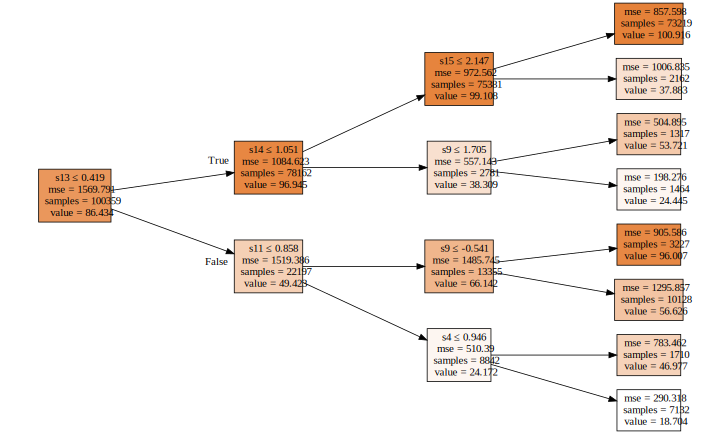

In [16]:
draw_tree(m.estimators_[0], df, precision=3)

In [17]:
m = RandomForestRegressor(n_estimators=1, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0, 29.969060434610448, 1.0, 0.40229513773551046]


In [18]:
m = RandomForestRegressor(n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[7.766621628651273, 22.141105268256144, 0.9615742397007493, 0.6737585585768247]


In [19]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
preds[:,0], np.mean(preds[:,0]), y_valid[0]

(array([120., 120., 120., 120.,  22.,  84., 120., 119., 120., 120.]),
 106.5,
 120.0)

In [20]:
preds.shape

(10, 60000)

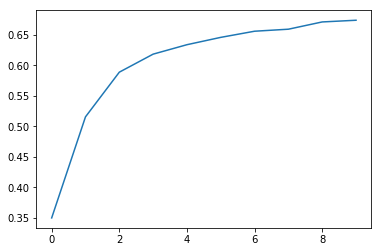

In [21]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(10)]);

## Bagging

In [22]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[7.129811936962946, 21.377188061498327, 0.967617205579084, 0.6958823054696659]


In [23]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.774631356721933, 21.26463085638529, 0.9707632220438366, 0.6990764131715541]


In [24]:
m = RandomForestRegressor(n_estimators=80, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[6.59397144573881, 21.084852808305698, 0.9723017521021936, 0.704143114616186]


In [25]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.786915969817286, 21.310862459328497, 0.9706570943076644, 0.6977665100590218, 0.7914118730423415]


In [26]:
df_trn, y_trn, nas = proc_df(train, 'RUL')
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(train, n_trn)

In [27]:
set_rf_samples(20000)


## Out-of-bag (OOB) score

In [28]:
m = RandomForestRegressor(n_jobs=-1, oob_score=True)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 9.09 s, sys: 68.3 ms, total: 9.16 s
Wall time: 1.9 s
[15.337915873046448, 22.971036760088417, 0.8501382235816676, 0.6488426787869568, 0.7802907632187763]


In [29]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[14.53130533501843, 22.575263129234322, 0.8654860176853085, 0.6608387901908798, 0.8002569696829978]


In [30]:
reset_rf_samples()

In [31]:
def dectree_max_depth(tree):
    children_left = tree.children_left
    children_right = tree.children_right

    def walk(node_id):
        if (children_left[node_id] != children_right[node_id]):
            left_max = 1 + walk(children_left[node_id])
            right_max = 1 + walk(children_right[node_id])
            return max(left_max, right_max)
        else: # leaf
            return 1

    root_node_id = 0
    return walk(root_node_id)

In [32]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[6.769413984379743, 21.248842344937287, 0.9708082371630002, 0.6995231053076105, 0.7912216370588899]


In [33]:
t=m.estimators_[0].tree_


In [34]:
dectree_max_depth(t)


48

## Hyperparameter Tuning

In [35]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[11.14136981897786, 21.754075440901428, 0.9209257004040046, 0.6850643719252019, 0.7984029923372727]


In [36]:
t=m.estimators_[0].tree_

In [37]:
dectree_max_depth(t)


42

In [38]:
set_rf_samples(50000)

In [39]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[12.442796030982462, 20.846507904523218, 0.9013733827914551, 0.7107940903004636, 0.8052799813584637]


### Using Pararllel Processing

In [40]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 668 ms, sys: 42.1 ms, total: 710 ms
Wall time: 709 ms


(103.86738095238096, 26.567496099173365)

In [41]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 134 ms, sys: 143 ms, total: 277 ms
Wall time: 331 ms


(103.86738095238096, 26.567496099173365)

## Feature Importance

In [43]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
#x.s14.value_counts().plot.barh();

In [46]:
flds = ['s13', 'RUL', 'pred', 'pred_std']
enc_summ = x[flds].groupby('s13', as_index=False).mean()
enc_summ

,s13,RUL,pred,pred_std
0,-2.393625,3.000000,20.670625,16.110838
1,-2.393391,4.000000,19.772321,13.653403
2,-2.393313,2.000000,23.946845,24.618796
3,-2.392689,0.000000,17.789405,12.854770
4,-2.392611,2.500000,22.795804,19.793860
5,-2.392299,19.000000,26.767173,16.716730
6,-2.392221,6.000000,19.387083,12.290935
7,-2.392143,5.500000,24.921429,25.719083
8,-2.392065,3.333333,20.886468,16.027914
9,-2.391909,4.500000,27.366354,25.231736


In [45]:
fi = rf_feat_importance(m, df); fi[:10]


,cols,imp
15,s13,0.218842
13,s11,0.192393
16,s14,0.094784
17,s15,0.082519
6,s4,0.077462
11,s9,0.061859
10,s8,0.045054
14,s12,0.039559
9,s7,0.032844
23,s21,0.022967


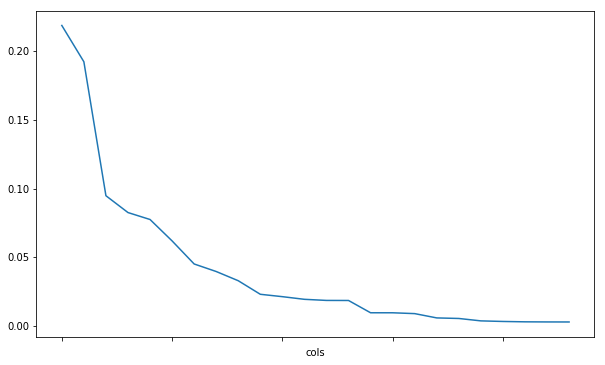

In [47]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [48]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

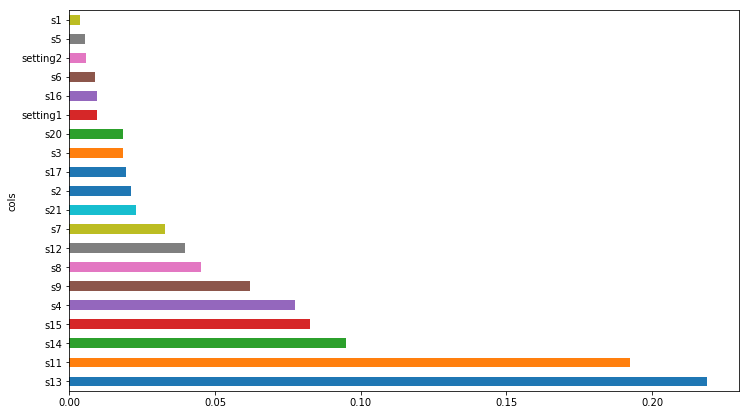

In [49]:
plot_fi(fi[:20]);


In [50]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)


19

In [51]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [52]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[12.481081423672913, 21.243082960216224, 0.9007655181431534, 0.699685968533612, 0.8052907331135615]


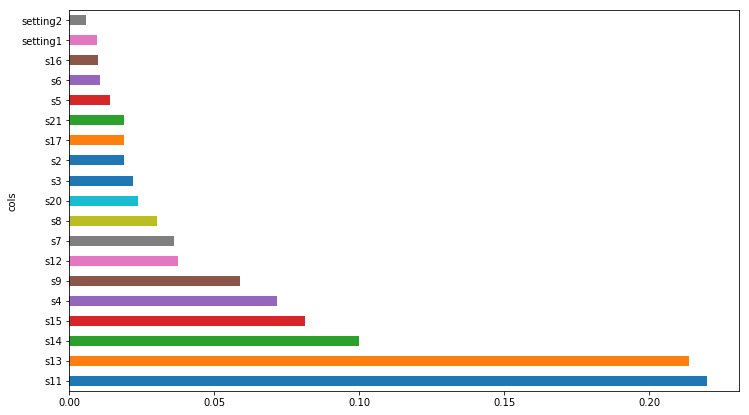

In [53]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

## Hierachical Clustering

In [54]:
from scipy.cluster import hierarchy as hc

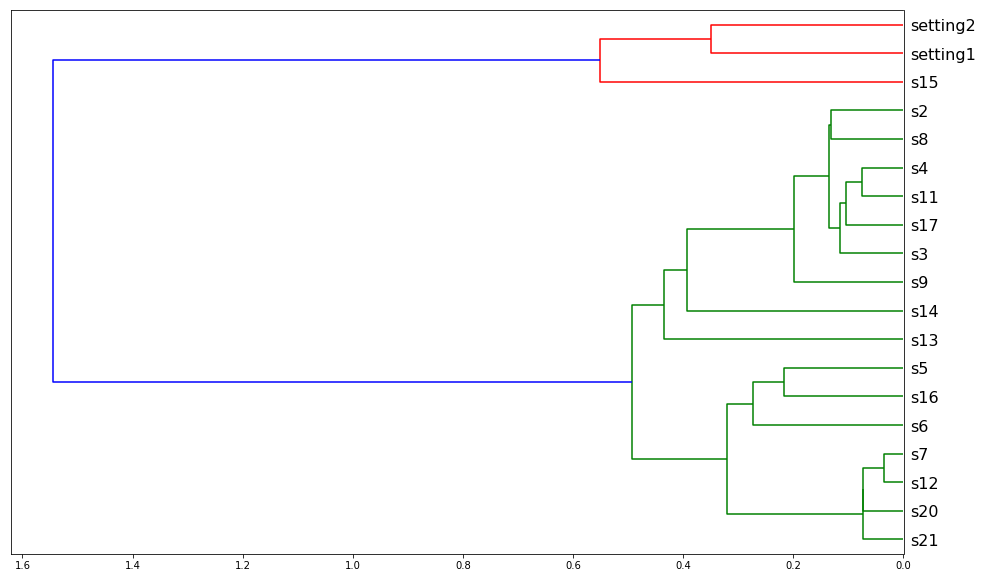

In [55]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

In [56]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

In [58]:
get_oob(df_keep)

0.8039038221105511

In [66]:
for c in ('s7', 's12', 's4', 's11', 's20', 's21','s2','s8'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

s7 0.8029662438737941
s12 0.8028893609794443
s4 0.8011004575197649
s11 0.7959989290383847
s20 0.803921659958277
s21 0.8039582051638009
s2 0.8029123534396738
s8 0.8023254209770301


In [67]:
to_drop = ['s17', 's4', 's2']
get_oob(df_keep.drop(to_drop, axis=1))

0.7979958762786963

# Summary
* Our best model can predict the remaining useful life (RUL) of the turbofan engine with an accuracy of 80%.

# Future Work
* Try using neural net with embedding matrices to see if we can get a better accuracy.
